In [15]:
import sys

if ".." not in sys.path:
    sys.path.insert(0, "..")

In [16]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import odeint, solve_ivp
from cobra.io import read_sbml_model
from tqdm import tqdm
from utils.cobra_utils import get_or_create_exchange
from utils.colors import *
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor, as_completed

BIOMASS_ID = "Rpom_hwa_biomass"
DATA_FILE = "../data/clean/CUE2/dFBA.pkl"

# Load and set up model
model = read_sbml_model("../model/Rpom_05.xml")
ex_glc = model.reactions.get_by_id("EX_glc")
ex_ace = get_or_create_exchange(model, "ACET[e]")

# Turn on maintenance
atpm = model.reactions.get_by_id("ATPM")
# atpm.bounds = (25, 25)

# Load condition data
with open(DATA_FILE, "rb") as f:
    data = pickle.load(f)

https://identifiers.org/stem/ does not conform to 'http(s)://identifiers.org/collection/id' or'http(s)://identifiers.org/COLLECTION:id
https://identifiers.org/stem/ does not conform to 'http(s)://identifiers.org/collection/id' or'http(s)://identifiers.org/COLLECTION:id
https://identifiers.org/stem/ does not conform to 'http(s)://identifiers.org/collection/id' or'http(s)://identifiers.org/COLLECTION:id
https://identifiers.org/stem/ does not conform to 'http(s)://identifiers.org/collection/id' or'http(s)://identifiers.org/COLLECTION:id
https://identifiers.org/stem/ does not conform to 'http(s)://identifiers.org/collection/id' or'http(s)://identifiers.org/COLLECTION:id
https://identifiers.org/stem/ does not conform to 'http(s)://identifiers.org/collection/id' or'http(s)://identifiers.org/COLLECTION:id
https://identifiers.org/stem/ does not conform to 'http(s)://identifiers.org/collection/id' or'http(s)://identifiers.org/COLLECTION:id
https://identifiers.org/stem/ does not conform to 'http

In [17]:
model.reactions.get_by_id("Rpom_hwa_biomass").reaction

'31.36179486 ATP[c] + 0.001524574 COFACTORS[c] + 0.05136379 DNA[c] + 0.009825009 IONS[c] + 0.095950926 LIPID[c] + 0.026355529 MUREIN[c] + 0.000447 NADP[c] + 0.001831 NAD[c] + 0.091372857 PHB-STORAGE[c] + 0.561521914 PROTEIN[c] + 0.093597842 RNA[c] + 48.601527 WATER[c] --> 31.36179573 ADP[c] + 31.36179573 PROTON[c] + 31.35745773 Pi[c]'

In [18]:
from collections import Counter

Counter([len(rxn.genes) for rxn in model.reactions])

Counter({1: 829,
         0: 612,
         2: 195,
         3: 152,
         4: 36,
         7: 10,
         5: 10,
         6: 7,
         9: 2,
         8: 2,
         11: 1,
         13: 1})

In [19]:
model.metabolites.get_by_id("GLYCEROL-3P[e]")

Metabolite identifier,GLYCEROL-3P[e]
Name,glycerol 3-phosphate
Memory address,0x775c5884c410
Formula,C3H7O6P
Compartment,e
In 2 reaction(s),"EX_GLYCEROL-3P, GLYCEROL-3Ptex"


In [20]:
# Plot data function for use later
def plot_data(ax,
              t_X_obs,
              X_obs_replicates,
              t_G_obs,
              G_obs_replicates,
              t_A_obs,
              A_obs_replicates,
              lw=2):
    ax.plot(t_X_obs, X_obs_replicates.T, marker="o", lw=0, color=C_BIOMASS, alpha=0.25)
    ax.plot(t_X_obs, X_obs_replicates.mean(axis=0), lw=lw, color=C_BIOMASS)
    
    # Plot whatever substrates present
    ax2 = ax.twinx()
    if not np.sum(G_obs_replicates) == 0:
        ax2.plot(t_G_obs, G_obs_replicates.T, marker="o", lw=lw, color=C_GLUCOSE)
    if not np.sum(A_obs_replicates) == 0:
        ax2.plot(t_A_obs, A_obs_replicates.T, marker="o", lw=lw, color=C_ACETATE)

    ax.set_xlabel("Time (h)")
    ax.set_ylabel("Biomass (g/L)", color=C_BIOMASS)
    ax2.set_ylabel("Substrate (mM)")

    return ax, ax2

Processing condition: 2.0 millimolar Glucose, 0.0 millimolar Acetate
Processing condition: 0.0 millimolar Glucose, 6.0 millimolar Acetate
Processing condition: 0.7 millimolar Glucose, 4.0 millimolar Acetate
Processing condition: 1.3 millimolar Glucose, 2.0 millimolar Acetate


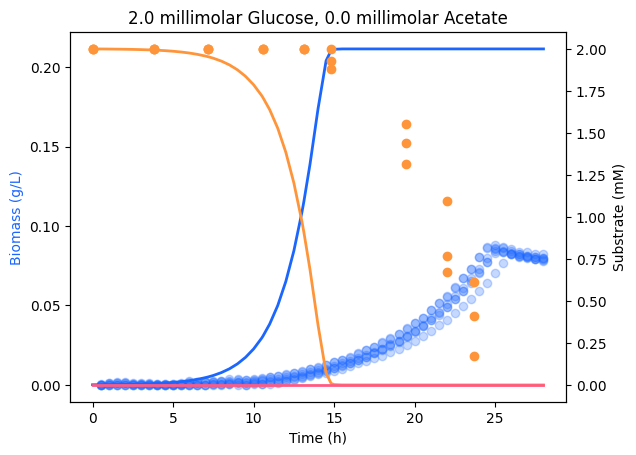

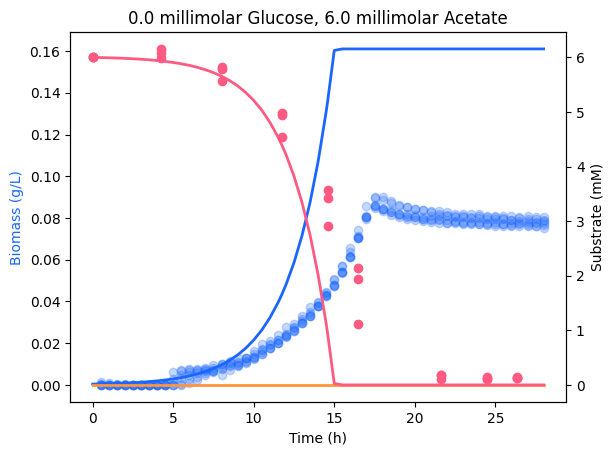

In [21]:
# Parameters
V_max_glc = 5.4357153539065965
K_M_glc = 0.14176287099345153
V_max_ace = 15.012683960622761
K_M_ace = 1.259066961884447e-07

for (g, a), dat in data.items():
    print(f"Processing condition: {g:.1f} Glucose, {a:.1f} Acetate")

    if g > 0 and a > 0:
        continue

    # Get raw data
    t_g = dat["raw"]["raw_g_t"]
    g_s = dat["raw"]["raw_g_s"]
    t_a = dat["raw"]["raw_a_t"]
    a_s = dat["raw"]["raw_a_s"]
    t_X = dat["raw"]["raw_b_t"]
    X_s = dat["raw"]["raw_b"]

    if len(g_s) == 0:
        g_s = np.zeros_like(a_s)
    if len(a_s) == 0:
        a_s = np.zeros_like(g_s)

    # Get initial condition
    X_0 = X_s.mean(axis=0)[0]
    g_0 = g_s.mean(axis=0)[0]
    a_0 = a_s.mean(axis=0)[0]

    def deriv(t, state):
        X, G, A, badness = state
        if badness == 0:
            bound_g = - V_max_glc * (G / (K_M_glc + G)) if G > 0 else 0
            bound_a = - V_max_ace * (A / (K_M_ace + A)) if A > 0 else 0
            with model:
                # atpm.bounds = (20, 20)
                ex_glc.bounds = (min(bound_g, 0), 0)
                ex_ace.bounds = (min(bound_a, 0), 0)
                sol = model.optimize()
            
            badness_grad = 0 if sol.status == "optimal" else 1
            return np.array([sol.objective_value,
                            sol.fluxes["EX_glc"],
                            sol.fluxes["EX_ac"],
                            badness_grad]) * X
        else:
            return np.array([0, 0, 0, 0])

    # Run numerical integration
    # (make sure to evaluate at all timepoints in X, G, and A data)
    t_eval = np.array(sorted(set(t_g) | set(t_a) | set(t_X)))

    # sol = odeint(deriv, np.array([X_0, g_0, a_0, 0]), t_eval)
    sol = solve_ivp(deriv, (t_eval[0], t_eval[-1]), np.array([X_0, g_0, a_0, 0]),
                    t_eval=t_eval, method="RK45")

    fig, ax = plt.subplots()
    _, ax2 = plot_data(ax, t_X, X_s, t_g, g_s, t_a, a_s, lw=0)
    ax.plot(t_eval, sol.y[0], color=C_BIOMASS, lw=2)
    ax2.plot(t_eval, sol.y[1], color=C_GLUCOSE, lw=2)
    ax2.plot(t_eval, sol.y[2], color=C_ACETATE, lw=2)
    ax.set_title(f"{g:.1f} Glucose, {a:.1f} Acetate")

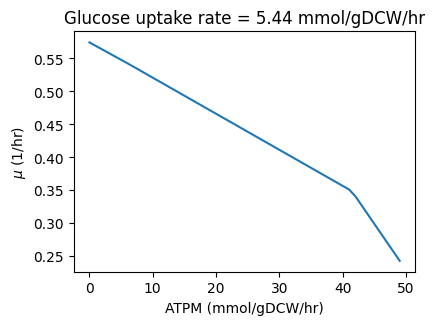

In [22]:
atpm_vals = np.arange(50)
growth_rates = []
with model:
    ex_glc.bounds = (-V_max_glc, 0)

    # model.reactions.get_by_id("6PFRUCTPHOS-RXN").bounds = (0, 0)

    for atpm_val in atpm_vals:
        atpm.bounds = (atpm_val, atpm_val)
        sol = model.optimize()
        growth_rates.append(sol.objective_value)

fig, ax = plt.subplots()
ax.set_title(f"Glucose uptake rate = {V_max_glc:.2f} mmol/gDCW/hr")
ax.plot(atpm_vals, growth_rates)
ax.set_xlabel("ATPM (mmol/gDCW/hr)")
ax.set_ylabel(r"$\mu$ (1/hr)")
fig.tight_layout()
fig.set_size_inches(4, 3)
        

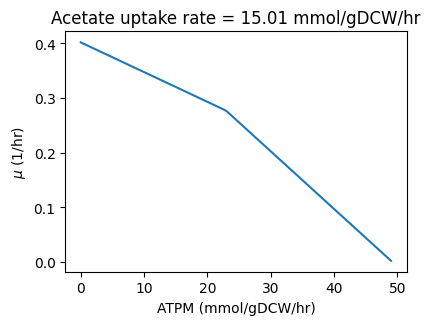

In [23]:
atpm_vals = np.arange(50)
growth_rates = []
with model:
    ex_ace.bounds = (-V_max_ace, 0)

    # model.reactions.get_by_id("6PFRUCTPHOS-RXN").bounds = (0, 0)

    for atpm_val in atpm_vals:
        atpm.bounds = (atpm_val, atpm_val)
        sol = model.optimize()
        growth_rates.append(sol.objective_value)

fig, ax = plt.subplots()
ax.set_title(f"Acetate uptake rate = {V_max_ace:.2f} mmol/gDCW/hr")
ax.plot(atpm_vals, growth_rates)
ax.set_xlabel("ATPM (mmol/gDCW/hr)")
ax.set_ylabel(r"$\mu$ (1/hr)")
fig.tight_layout()
fig.set_size_inches(4, 3)

2.0 millimolar Glucose, 0.0 millimolar Acetate: 1it [00:01,  1.30s/it]/home/myang42/.pyenv/versions/3.12.1/envs/rpom/lib/python3.12/site-packages/cobra/util/solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
2.0 millimolar Glucose, 0.0 millimolar Acetate: 20it [00:42,  2.12s/it]
0.0 millimolar Glucose, 6.0 millimolar Acetate: 20it [00:12,  1.57it/s]
0.7 millimolar Glucose, 4.0 millimolar Acetate: 20it [00:37,  1.88s/it]
1.3 millimolar Glucose, 2.0 millimolar Acetate: 20it [00:40,  2.01s/it]


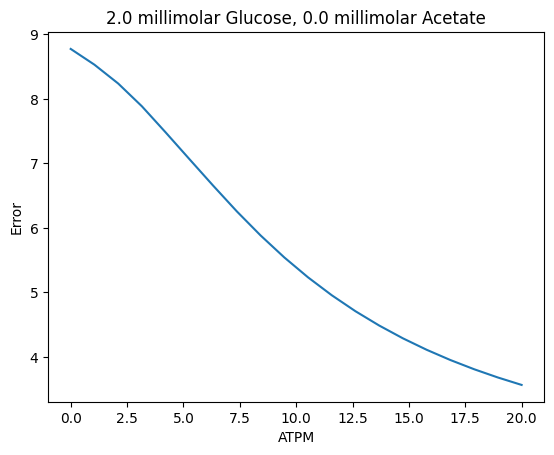

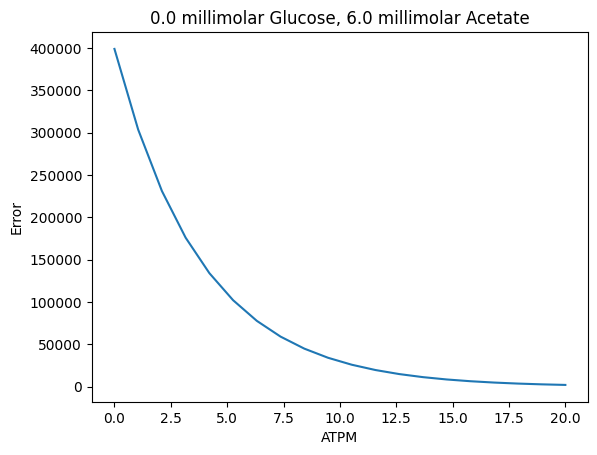

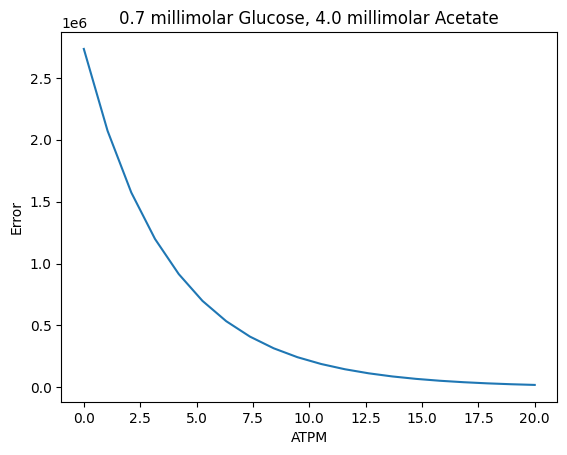

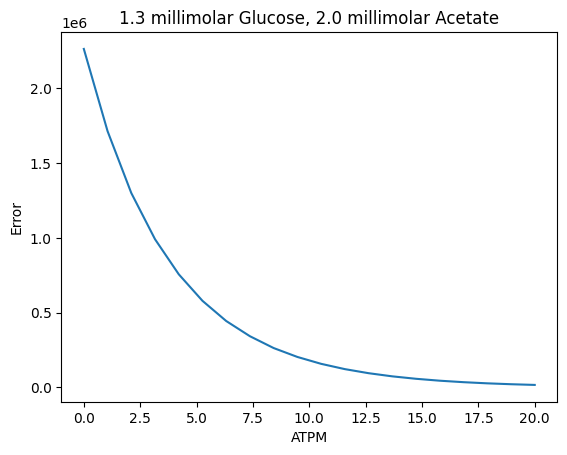

In [24]:
# Error function for data vs. model
def err(t_X, X_obs_replicates,
        t_g, G_obs_replicates,
        t_a, A_obs_replicates,
        t_eval, model_X, model_G, model_A):
    model_X = model_X[np.isin(t_eval, t_X)]
    model_G = model_G[np.isin(t_eval, t_g)]
    model_A = model_A[np.isin(t_eval, t_a)]
    return (
        np.sum((X_obs_replicates.mean(axis=0) - model_X)**2)
        + np.sum((G_obs_replicates.mean(axis=0) - model_G)**2)
        + np.sum((A_obs_replicates.mean(axis=0) - model_A)**2)
    )

for (g, a), dat in data.items():

    # Get raw data
    t_g = dat["raw"]["raw_g_t"]
    g_s = dat["raw"]["raw_g_s"]
    t_a = dat["raw"]["raw_a_t"]
    a_s = dat["raw"]["raw_a_s"]
    t_X = dat["raw"]["raw_b_t"]
    X_s = dat["raw"]["raw_b"]

    if len(g_s) == 0:
        g_s = np.zeros_like(a_s)
    if len(a_s) == 0:
        a_s = np.zeros_like(g_s)

    # Get initial condition
    X_0 = X_s.mean(axis=0)[0]
    g_0 = g_s.mean(axis=0)[0]
    a_0 = a_s.mean(axis=0)[0]

    # Define derivative
    def deriv(t, state):
        X, G, A, badness = state
        if badness == 0:
            bound_g = - V_max_glc * (G / (K_M_glc + G))
            bound_a = - V_max_ace * (A / (K_M_ace + A))
            with model:
                ex_glc.bounds = (min(bound_g, 0), 0)
                ex_ace.bounds = (min(bound_a, 0), 0)
                sol = model.optimize()
            
            badness_grad = 0 if sol.status == "optimal" else 1
            return np.array([sol.objective_value,
                            sol.fluxes["EX_glc"],
                            sol.fluxes["EX_ac"],
                            badness_grad]) * X
        else:
            return np.array([0, 0, 0, 0])
    
    # def work(model, atpm_val):
    #     with model:
    #         # Set maintenance
    #         atpm.bounds = (atpm_val, atpm_val)

    #         # Run numerical integration
    #         # (make sure to evaluate at all timepoints in X, G, and A data)
    #         t_eval = np.array(sorted(set(t_g) | set(t_a) | set(t_X)))
    #         sol = odeint(deriv, np.array([X_0, g_0, a_0]), t_eval)

    #         model_X, model_G, model_A = sol.T
    #         return err(
    #             t_X, X_s, t_g, g_s, t_a, a_s,
    #             t_eval, model_X, model_G, model_A
    #         )


    atpm_vals = np.linspace(0, 20, 20)
    errors = np.zeros_like(atpm_vals)

    # futures = {}
    # with ThreadPoolExecutor() as ex:
    #     for i, atpm_val in tqdm(enumerate(atpm_vals), "Submitting..."):
    #         future = ex.submit(work, model, atpm_val)
    #         futures[future] = i
    
    # for future in tqdm(as_completed(futures), "Collecting..."):
    #     i = futures[future]
    #     errors[i] = future.result()


    for i, atpm_val in tqdm(enumerate(atpm_vals), desc=f"{g:.1f} Glucose, {a:.1f} Acetate"):
        with model:
            # Set maintenance
            atpm.bounds = (atpm_val, atpm_val)

            # Run numerical integration
            # (make sure to evaluate at all timepoints in X, G, and A data)
            t_eval = np.array(sorted(set(t_g) | set(t_a) | set(t_X)))
            sol = solve_ivp(deriv, (t_eval[0], t_eval[-1]), np.array([X_0, g_0, a_0, 0]),
                    t_eval=t_eval, method="RK45")

            model_X, model_G, model_A, _ = sol.y
            errors[i] = err(
                t_X, X_s, t_g, g_s, t_a, a_s,
                t_eval, model_X, model_G, model_A
            )
    
    fig, ax = plt.subplots()
    ax.plot(atpm_vals, errors)
    ax.set_title(f"{g:.1f} Glucose, {a:.1f} Acetate")
    ax.set_xlabel("ATPM")
    ax.set_ylabel("Error")

In [25]:
# # Error function for data vs. model
# def err(t_X, X_obs_replicates,
#         t_g, G_obs_replicates,
#         t_a, A_obs_replicates,
#         t_eval, model_X, model_G, model_A):
#     model_X = model_X[np.isin(t_eval, t_X)]
#     model_G = model_G[np.isin(t_eval, t_g)]
#     model_A = model_A[np.isin(t_eval, t_a)]
#     return (
#         np.sum((X_obs_replicates.mean(axis=0) - model_X)**2)
#         + np.sum((G_obs_replicates.mean(axis=0) - model_G)**2)
#         + np.sum((A_obs_replicates.mean(axis=0) - model_A)**2)
#     )

# # Define derivative
# def deriv(state, t):
#     X, G, A = state
#     bound_g = - V_max_glc * (G / (K_M_glc + G))
#     bound_a = - V_max_ace * (A / (K_M_ace + A))
#     with model:
#         ex_glc.bounds = (min(bound_g, 0), 0)
#         ex_ace.bounds = (min(bound_a, 0), 0)
#         sol = model.optimize()
#     return np.array([sol.objective_value,
#                     sol.fluxes["EX_glc"],
#                     sol.fluxes["EX_ac"]]) * X

# atpm_vals = np.linspace(0, 10, 10)

# futures = {}
# with ThreadPoolExecutor(max_workers=4) as ex:
#     for (g, a), dat in tqdm(data.items(), "Submitting..."):
#         # Get raw data
#         t_g = dat["raw"]["raw_g_t"]
#         g_s = dat["raw"]["raw_g_s"]
#         t_a = dat["raw"]["raw_a_t"]
#         a_s = dat["raw"]["raw_a_s"]
#         t_X = dat["raw"]["raw_b_t"]
#         X_s = dat["raw"]["raw_b"]

#         if len(g_s) == 0:
#             g_s = np.zeros_like(a_s)
#         if len(a_s) == 0:
#             a_s = np.zeros_like(g_s)

#         # Get initial condition
#         X_0 = X_s.mean(axis=0)[0]
#         g_0 = g_s.mean(axis=0)[0]
#         a_0 = a_s.mean(axis=0)[0]
        
#         def work(model, atpm_val,
#                  t_g, g_s,
#                  t_a, a_s,
#                  t_X, X_s):
#             with model:
#                 # Set maintenance
#                 atpm.bounds = (atpm_val, atpm_val)

#                 # Run numerical integration
#                 # (make sure to evaluate at all timepoints in X, G, and A data)
#                 t_eval = np.array(sorted(set(t_g) | set(t_a) | set(t_X)))
#                 sol = solve_ivp(deriv, (t_eval[0], t_eval[-1]), np.array([X_0, g_0, a_0, 0]),
#                     t_eval=t_eval, method="RK45")

#                 model_X, model_G, model_A, _ = sol.y
#                 return err(
#                     t_X, X_s, t_g, g_s, t_a, a_s,
#                     t_eval, model_X, model_G, model_A
#                 )

#         errors = np.zeros_like(atpm_vals)
#         for i, atpm_val in enumerate(atpm_vals):
#             future = ex.submit(work, model.copy(), atpm_val, t_g, g_s, t_a, a_s, t_X, X_s)
#             futures[future] = ((g, a), i, atpm_val)

# errors = {(g, a) : np.zeros_like(atpm_vals)}
# for future in tqdm(as_completed(futures), "Collecting..."):
#     ((g, a), i, atpm_val) = futures[future]
#     errors[(g, a)][i] = future.result()


#         # for i, atpm_val in tqdm(enumerate(atpm_vals), desc=f"{g:.1f} Glucose, {a:.1f} Acetate"):
#         #     with model:
#         #         # Set maintenance
#         #         atpm.bounds = (atpm_val, atpm_val)

#         #         # Run numerical integration
#         #         # (make sure to evaluate at all timepoints in X, G, and A data)
#         #         t_eval = np.array(sorted(set(t_g) | set(t_a) | set(t_X)))
#         #         sol = odeint(deriv, np.array([X_0, g_0, a_0]), t_eval)

#         #         model_X, model_G, model_A = sol.T
#         #         errors[i] = err(
#         #             t_X, X_s, t_g, g_s, t_a, a_s,
#         #             t_eval, model_X, model_G, model_A
#         #         )

# for (g, a), errs in errors.items():
#     fig, ax = plt.subplots()
#     ax.plot(atpm_vals, errs)
#     ax.set_title(f"{g:.1f} Glucose, {a:.1f} Acetate")
#     fig.show()

In [26]:
with model:
    fumhydr = model.reactions.get_by_id("FUMHYDR-RXN")
    
    ex_glc.bounds = (-V_max_glc, 0)

    print(model.optimize().objective_value)

    fumhydr.bounds = (-1000, -1000)

    print(model.optimize().objective_value)
    print(fumhydr.flux)

0.5742537254582754
0.5742537254567976
-1000.0


In [27]:
model.reactions.get_by_id("UREIDOGLYCOLATE-LYASE-RXN").genes

frozenset({<Gene SPO0873 at 0x775c58655eb0>})

In [28]:
model.metabolites.get_by_id("D-GLUCOSAMINE-6-P[c]").reactions
# model.reactions.get_by_id("NAG6PDEACET-RXN")

KeyError: 'D-GLUCOSAMINE-6-P[c]'

In [ ]:
for rxn in model.metabolites.get_by_id("CPD-13469[c]").reactions:
    print(f"{rxn.id}\n\t{rxn.reaction}")

5.4.2.10-RXN-CPD-13469//GLUCOSAMINE-1P.26.
	CPD-13469[c] <=> GLUCOSAMINE-1P[c]
GLUCOSAMINE-6-P-DEAMIN-RXN
	CPD-13469[c] + WATER[c] <=> AMMONIUM[c] + FRUCTOSE-6P[c]
L-GLN-FRUCT-6-P-AMINOTRANS-RXN-FRUCTOSE-6P/GLN//CPD-13469/GLT.31.
	FRUCTOSE-6P[c] + GLN[c] <=> CPD-13469[c] + GLT[c]
NAG6PDEACET-RXN-N-ACETYL-D-GLUCOSAMINE-6-P/WATER//CPD-13469/ACET.49.
	N-ACETYL-D-GLUCOSAMINE-6-P[c] + WATER[c] --> ACET[c] + CPD-13469[c]


In [ ]:
for rxn in model.metabolites.get_by_id("FORMATE[c]").reactions:
    print(f"{rxn.id}\n\t{rxn.reaction}")

RXN-11054
	CYCLOHEX-13-DIENE-56-DIHYDROXY-1-CARBO[c] + 2.0 WATER[c] --> CPD-12012[c] + FORMATE[c] + PROTON[c]
RXN-7592
	FORMYL-ISOGLUTAMINE[c] + WATER[c] --> FORMATE[c] + ISOGLUTAMINE[c]
FHLMULTI-RXN
	FORMATE[c] + PROTON[c] --> CARBON-DIOXIDE[c] + HYDROGEN-MOLECULE[c]
ARYLFORMAMIDASE-RXN
	N-FORMYLKYNURENINE[c] + WATER[c] --> CPD-14736[c] + FORMATE[c] + PROTON[c]
GTP-CYCLOHYDRO-I-RXN
	GTP[c] + WATER[c] --> DIHYDRONEOPTERIN-P3[c] + FORMATE[c] + PROTON[c]
GTP-CYCLOHYDRO-II-RXN
	GTP[c] + 3.0 WATER[c] --> DIAMINO-OH-PHOSPHORIBOSYLAMINO-PYR[c] + FORMATE[c] + PPI[c] + 2.0 PROTON[c]
PYRUVFORMLY-RXN
	CO-A[c] + PYRUVATE[c] --> ACETYL-COA[c] + FORMATE[c]
RXN-12612
	CPD-13577[c] + WATER[c] --> CPD-13578[c] + FORMATE[c]
N-FORMYLGLUTAMATE-DEFORMYLASE-RXN
	CPD-600[c] + WATER[c] --> FORMATE[c] + GLT[c]
S-FORMYLGLUTATHIONE-HYDROLASE-RXN
	CPD-548[c] + WATER[c] --> FORMATE[c] + GLUTATHIONE[c] + PROTON[c]
1.2.1.2-RXN
	FORMATE[c] + NAD[c] --> CARBON-DIOXIDE[c] + NADH[c]
KETOBUTFORMLY-RXN
	2-OXOBUTANOATE[c]

In [ ]:
model.reactions.get_by_id("RXNI-2").annotation

{'EC Number': '2.8.3.5', 'Kegg ID': 'R00410', 'stem': 'RXNI-2'}

In [ ]:
with model:
    # Set all carbon sources to 0
    for ex in model.exchanges:
        if "C" in list(ex.metabolites)[0].formula:
            ex.lower_bound = 0
            ex.upper_bound = 0
    atpm = model.reactions.get_by_id("ATPM")
    atpm.bounds = (0, 1000)
    model.objective = atpm
    sol = model.optimize()
for rxn in sol.fluxes[sol.fluxes != 0].index:
    print(f"{rxn}: {sol.fluxes[rxn]:.2f}\n\t{model.reactions.get_by_id(rxn).reaction}")

ABC-24-RXN: 1000.00
	ATP[c] + SPERMIDINE[p] + WATER[c] --> ADP[c] + PROTON[c] + Pi[c] + SPERMIDINE[c]
ATPM: 1000.00
	ATP[c] + WATER[c] --> ADP[c] + PROTON[c] + Pi[c]
SPERMIDINEtpp: -1000.00
	2.0 ATP[c] + SPERMIDINE[p] + 2.0 WATER[c] <=> 2.0 ADP[c] + 2.0 PROTON[c] + 2.0 Pi[c] + SPERMIDINE[c]


In [ ]:
model.reactions.get_by_id('RXN-11738').check_mass_balance()

NameError: name 'model' is not defined

In [ ]:
model.reactions.get_by_id("AACPS4").annotation

{'stem': 'AACPS4'}

In [ ]:
for rxn in model.metabolites.get_by_id("5-AMINO-LEVULINATE[c]").reactions:
    print(f"{rxn.id}\n\t{rxn.reaction}")

5-AMINOLEVULINIC-ACID-SYNTHASE-RXN
	GLY[c] + PROTON[c] + SUC-COA[c] --> 5-AMINO-LEVULINATE[c] + CARBON-DIOXIDE[c] + CO-A[c]
GSAAMINOTRANS-RXN
	GLUTAMATE-1-SEMIALDEHYDE[c] --> 5-AMINO-LEVULINATE[c]
RXN-15714
	5-AMINO-LEVULINATE[c] + ATP[c] + CO-A[c] <=> AMP[c] + CPD-16937[c] + PPI[c]
PORPHOBILSYNTH-RXN
	2.0 5-AMINO-LEVULINATE[c] --> PORPHOBILINOGEN[c] + PROTON[c] + 2.0 WATER[c]


In [ ]:
list(model.metabolites.get_by_id('POLYMER-INST-CIS-DELTA3-ENOYL-COA-C12-H24[c]').reactions)[0]

Reaction identifier,ENOYL-COA-DELTA-ISOM-RXN-POLYMER-INST-CIS-DELTA3-ENOYL-COA-C12-H24//CPD0-2117.53.
Name,ENOYL-COA-DELTA-ISOM-RXN-POLYMER-INST-CIS-DELTA3-ENOYL-COA-C12-H24//CPD0-2117.53.
Memory address,0x7f374b6c6420
Stoichiometry,POLYMER-INST-CIS-DELTA3-ENOYL-COA-C12-H24[c] <=> CPD0-2117[c] POLYMER-INST-CIS-DELTA3-ENOYL-COA-C12-H24 <=> (2E)-hexadecenoyl-CoA
GPR,SPO0740
Lower bound,-1000.0
Upper bound,1000.0


In [ ]:
from cobra.io import load_model

ecoli = load_model("iJO1366")
with ecoli:
    ecoli.reactions.get_by_id("EX_glc__D_e").bounds = (-10, 0)

    print(ecoli.optimize())

<Solution 0.982 at 0x7fcfabe104a0>


In [ ]:
from cobra.util.array import create_stoichiometric_matrix
from scipy.linalg import null_space

S = create_stoichiometric_matrix(model)
ns = null_space(S)


array([[-2.68132200e-04,  3.74440510e-04,  1.05848885e-04, ...,
         5.02040731e-04,  5.13304109e-05,  1.70412147e-04],
       [ 4.61859350e-02,  4.04055296e-03, -1.94324076e-02, ...,
         1.57134802e-02,  7.76639392e-03, -2.16592917e-02],
       [-7.71361677e-01, -4.31004275e-02,  2.51762323e-02, ...,
         1.42218617e-02,  3.32593990e-03, -1.17371840e-02],
       ...,
       [ 6.11490025e-17,  3.49113100e-17,  1.00613962e-16, ...,
         3.33934269e-17, -6.46184495e-17, -1.31188463e-17],
       [-7.32920669e-17,  1.97324795e-17, -2.38524478e-17, ...,
        -5.06322415e-17,  1.07878116e-17,  1.07607066e-16],
       [ 1.38777878e-17, -3.10081821e-17, -5.38306379e-17, ...,
        -3.25260652e-18,  1.46773869e-17, -4.97648797e-17]])

In [ ]:
biomass_i = model.reactions.index("Rpom_hwa_biomass")
for vec in ns.T:
    if vec[biomass_i] != 0:
        print(f"{vec[biomass_i]:.2g}")

-0.0036
0.005
0.0014
-0.0042
0.0018
-0.0027
0.0079
0.00031
-0.0059
-0.00018
-0.0045
-0.0039
-0.00029
0.0047
-0.00025
0.0038
0.002
-0.0034
-0.0025
-0.0019
-0.0018
0.00053
-0.0075
-0.0033
0.0026
-0.0014
-0.00012
-0.0032
-0.00082
0.0067
0.0098
0.0023
0.0025
-0.0029
0.0039
0.0083
-0.0016
-0.00039
0.0027
0.00096
-0.0037
0.002
-0.0024
-0.00091
0.00035
-0.0011
-0.0068
0.0058
-0.0079
0.00074
-0.0035
-0.0022
0.0013
-0.00026
0.0044
0.0035
0.004
0.0074
0.0014
-2.7e-05
-0.0011
0.00087
-0.00057
0.006
-0.00049
0.0013
0.0056
0.0053
0.0061
-0.00091
-0.0075
-0.0038
-0.0051
-0.0021
0.0047
0.006
-0.012
0.0035
0.0034
0.00082
-0.0031
-0.00063
0.002
0.0036
-0.01
0.0068
-0.0051
0.00077
-0.00023
0.0013
0.0055
-0.0036
-0.00026
0.012
0.00077
-0.0024
0.0057
0.0082
0.0012
-0.0028
0.0039
-0.0015
-0.0031
0.0011
0.0024
0.0048
-0.0061
0.0041
0.0065
0.00024
-0.012
0.0036
-0.0018
0.0028
0.0041
-0.0039
-0.0042
0.0016
0.0037
0.0016
0.0046
-0.00042
0.0022
0.00059
0.0029
-0.00017
-0.011
-0.00061
-0.002
0.0062
-0.0056
0.000

In [ ]:
model.reactions.get_by_id("RXN-7744")

Reaction identifier,RXN-7744
Name,
Memory address,0x7f2971e00aa0
Stoichiometry,"2-METHYLMALEATE[c] + WATER[c] --> CPD-7066[c] citraconate + H2O --> (2R,3S)-3-methylmalate"
GPR,SPO_RS01105
Lower bound,0.0
Upper bound,1000.0


In [ ]:
model.metabolites.get_by_id("2-METHYLMALEATE[c]").formula
# model.metabolites.get_by_id("WATER[c]")
# model.metabolites.get_by_id("CPD-7066[c]").formula

'C5H4O4'

In [ ]:
model.metabolites.get_by_id("CADAVERINE[c]")

Metabolite identifier,CADAVERINE[c]
Name,cadaverine
Memory address,0x7f29729bfd40
Formula,C5H16N2
Compartment,c
In 1 reaction(s),CADAVERINEtpp


In [ ]:
model.reactions.get_by_id("RNA-RXN").metabolites

{<Metabolite CTP[c] at 0x7f2972b4af00>: -0.401180745,
 <Metabolite GTP[c] at 0x7f2972b78c20>: -0.646346089,
 <Metabolite UTP[c] at 0x7f29729948c0>: -0.433020869,
 <Metabolite ATP[c] at 0x7f2972c30b30>: -0.880652677,
 <Metabolite RNA[c] at 0x7f2972a4f6b0>: 1.0,
 <Metabolite ADP[c] at 0x7f2972b48890>: 0.35529704,
 <Metabolite PROTON[c] at 0x7f2972ada690>: 0.35529704,
 <Metabolite Pi[c] at 0x7f2972b485f0>: 0.35529704,
 <Metabolite PPI[c] at 0x7f2972b4a540>: 2.00590334}